# Create 2D horizontal plots
**Author: Jun Sasaki  Coded on 2025-01-13  Updated on 2025-01-22**<br>
Create a 2D horizontal contour plots. Customization can be made by defining `post_process_func`, or `post_process_func=None` (default) without customization. 

```Python
def post_process_func(ax, da, time):
    """
    Example of post_process_func for customizing plot (e.g., add text or markers)
    
    Parameters:
    - ax: matplotlib axis.
    - da: DataArray (optional and used for dynamic customizing).
    - time: Frame time (optional and used for dynamic customizing).
    """
```

In [1]:
import os
import numpy as np
import pandas as pd
from xfvcom import FvcomDataLoader, FvcomPlotConfig, FvcomPlotter
from xfvcom.helpers import FrameGenerator
from xfvcom.helpers_utils import apply_xlim_ylim
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.tri as tri

## Prepare FvcomDataLoader instance of `fvcom` using FVCOM output netcdf.
Dataset is `fvcom.ds`.

In [2]:
# Loading FVCOM output netcdf
output_dir = "./"
output_dir = os.path.expanduser(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
base_path = "~/Github/TB-FVCOM/goto2023"
#base_path =  "/home/pj24001722/ku40003295/Ersem_TokyoBay/output_5times"
base_path = os.path.expanduser(base_path)
# List of netcdf files convenient to switch to another netcdf by specifying its index
ncfiles = ["TokyoBay18_r16_crossed_0001.nc"]
#ncfiles = ["tb_0001.nc"]
index_ncfile = 0
# Loading FVCOM input open boundary node file of tst_obc.dat.
obcfile_path =  f"{base_path}/input/TokyoBay18_obc.dat"
# Create an instance of FvcomDataLoader where fvcom.ds is a Dataset
fvcom = FvcomDataLoader(base_path=f"{base_path}/output", ncfile=ncfiles[index_ncfile], obcfile_path=obcfile_path, time_tolerance=5)
cfg = FvcomPlotConfig(figsize=(6, 8))
plotter = FvcomPlotter(fvcom.ds, cfg)

Dataset loaded successfully from /home/teem/Github/TB-FVCOM/goto2023/output/TokyoBay18_r16_crossed_0001.nc
Open boundary nodes loaded successfully from /home/teem/Github/TB-FVCOM/goto2023/input/TokyoBay18_obc.dat


In [3]:
fvcom.ds

<xarray.Dataset> Size: 1GB
Dimensions:    (nele: 5645, node: 3210, siglay: 30, siglev: 31, three: 3,
                time: 72, maxnode: 11, maxelem: 9, four: 4, dim_0: 5645,
                dim_1: 3, obc_node: 13)
Coordinates:
    x          (node) float64 26kB ...
    y          (node) float64 26kB ...
    lon        (node) float64 26kB 139.8 139.8 139.8 139.8 ... 139.8 139.9 139.8
    lat        (node) float64 26kB 35.65 35.65 35.65 35.65 ... 34.99 34.99 34.99
    lonc       (nele) float64 45kB 139.8 139.8 139.8 139.8 ... 139.9 139.8 139.9
    latc       (nele) float64 45kB 35.65 35.65 35.65 35.65 ... 35.0 34.99 34.99
    siglay     (siglay, node) float64 770kB ...
    siglev     (siglev, node) float64 796kB ...
  * time       (time) datetime64[ns] 576B 2020-01-01T01:00:00 ... 2020-01-12T...
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four,
                                dim_0, dim_1, obc_node
Data variables: (12/42)
    nprocs     int32 4B ...
    partition  (nele) int32 23kB ...
    xc         (nele) float64 45kB ...
    yc         (nele) float64 45kB ...
    h          (node) float64 26kB ...
    nv         (three, nele) int32 68kB ...
    ...         ...
    l          (time, siglev, node) float64 57MB ...
    z          (time, siglay, node) float64 55MB -0.0719 -0.0666 ... -3.88
    z_dfs      (time, siglay, node) float64 55MB 0.07187 0.06657 ... 3.749 3.737
    nv_zero    (dim_0, dim_1) int32 68kB 1 2 0 0 2 ... 3207 3206 3209 3206 3208
    nv_ccw     (nele, three) int32 68kB 0 2 1 3 2 0 ... 3207 3209 3208 3206 3209
    node_bc    (obc_node) int64 104B 3149 3141 3136 3124 ... 3053 3036 3015 3014
Attributes: (12/14)
    title:                       TokyoBay18_r16_crossed
    institution:                 School for Marine Science and Technology
    source:                      FVCOM_4.4.7
    history:                     model started at: 20/11/2024   18:52
    references:                  http://fvcom.smast.umassd.edu, https://githu...
    Conventions:                 CF-1.0
    ...                          ...
    Tidal_Forcing:               Tidal Forcing Time Series Title: Model surfa...
    River_Forcing:               THERE ARE 22 RIVERS IN THIS MODEL.\nRIVER IN...
    GroundWater_Forcing:         GROUND WATER FORCING IS OFF!
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    Surface_Wind_Forcing:        FVCOM variable surface Wind forcing:\nFILE N...
    Surface_PrecipEvap_Forcing:  SURFACE PRECIPITATION FORCING IS OFF

## Bathymetry and mesh plot
Plots can be modified by applying `post_process_func` (optional). 

In [4]:
fvcom.ds.lon.values

array([139.767538, 139.770648, 139.765376, ..., 139.837747, 139.856127,
       139.848785])

Plotting coastlines...
Plotting open boundary lines...
Set extent: x_min=139.9, x_max=140.0, y_min=35.6, y_max=35.7


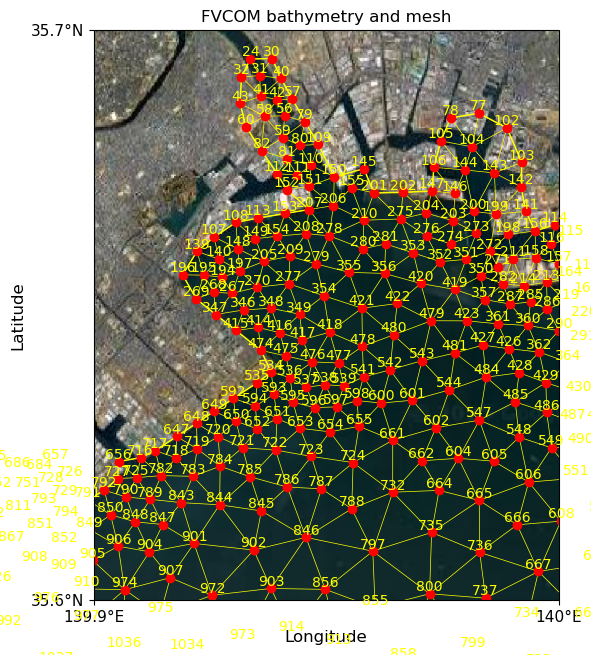

In [5]:
def custom_plot_bathymetry(ax):
    """
    Customizing plot by updating ax

    Parameters:
    - ax: matplotlib axis
    """

    # Further customization can be added.
    ax.set_title("FVCOM bathymetry and mesh")
    transform=ccrs.PlateCarree()
    lon = fvcom.ds.lon.values
    lat = fvcom.ds.lat.values
    for n in range(len(fvcom.ds.lon)):
        ax.text(lon[n], lat[n], str(n+1), fontsize=10, color='yellow', ha='center', va='bottom',
                transform=transform, clip_on=True)
        ax.plot(lon[n], lat[n], 'ro', transform=transform, clip_on=True)  # Marker plot at (lon, lat)
    
    # Set xlim and ylim manually.
    xlim = ("139:40:00", "140:00:00")
    ylim = ("35:12:00", "35:50")
    xlim = (139.9, 140.0)
    ylim = (35.6, 35.7)
    #xlim = (139.7, 140.1)
    #ylim = (35, 35.6)

    apply_xlim_ylim(ax, xlim, ylim, is_cartesian=False)

# Specify bathymetry
var_name = "h"
da = plotter.ds[var_name]
da = None # only mesh plot

# Set plot_kwargs for `ax.tricontourf()` kwargs, including `**kwargs`.
vmin = 0; vmax = 500  # = None for automated
levels = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 50, 100, 200, 300, 400, 500]
# levels = 20
cmap = "jet"  # "jet", "Blues"
plot_kwargs={"verbose": False, "vmin": vmin, "vmax": vmax, "levels": levels,
             "cmap": cmap, "with_mesh": True, "coastlines": True, "obclines": True,
             "plot_grid": False, "add_tiles": True, "color": "yellow", "coastline_color": "yellow"}
# plot_kwargs={} # Default plot
save_path = os.path.join(output_dir, f"{var_name}.png")

ax = FrameGenerator.plot_data(data_array=da, plotter=plotter,
    save_path=None, post_process_func=custom_plot_bathymetry, plot_kwargs=plot_kwargs)
fig=ax.figure
ax.set_extent([139.9, 140.0, 35.6, 35.7], crs=ccrs.PlateCarree())
fig.savefig(save_path, bbox_inches='tight', dpi=300)

## Create 2D plot with `post_process_func`.
- 2-D horizontal plot with customization by updating `ax` `if post_process_func is not None`.

Plotting coastlines...
Plotting open boundary lines...


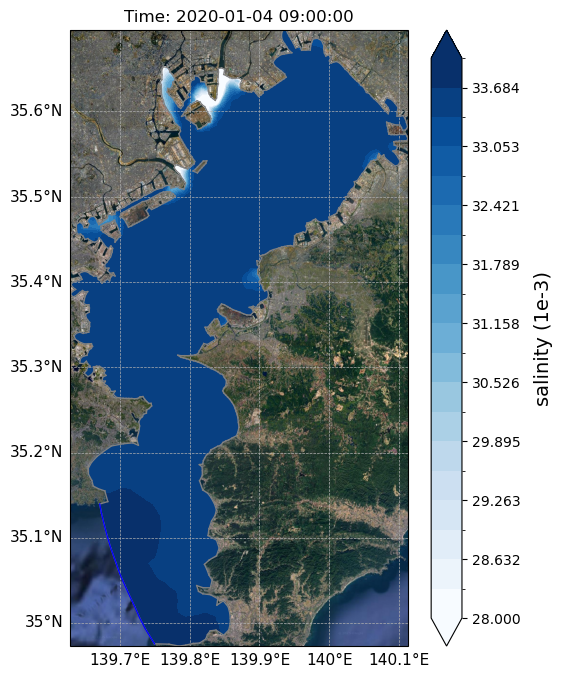

In [6]:
def static_custom_plot(ax):
    """
    Customizing plot by updating ax

    Parameters:
    - ax: matplotlib axis
    """

    # Further customization can be added.
    ax.set_title("Title with Custom Plot")

def dynamic_custom_plot(ax, da, time):
    """
    Plot the corresponding datetime at each frame

    Parameters:
    - ax: matplotib axis.
    - da: DataArray.
    - time: Frame time.    
    """
    datetime = pd.Timestamp(da.time.item()).strftime('%Y-%m-%d %H:%M:%S')
    ax.set_title(f"Time: {datetime}")

# Specify var_name and siglay if any
var_name = "salinity"
time = 20
siglay = 0
da = plotter.ds[var_name][:,siglay,:] # time must be included in da as reusing a tool for animation.
time_str = fvcom.ds.time.isel(time=time).values
time_str = pd.to_datetime(time_str).strftime("%Y%m%d")
# Set plot_kwargs for `ax.tricontourf(**kwargs)`.
plot_kwargs={"verbose": False, "vmin": 10, "vmax": 20, "levels": [9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 15, 16, 17, 18, 19, 20]}
plot_kwargs={"verbose": False, "vmin": 28, "vmax": 34, "levels": 20, "cmap": "jet"}
plot_kwargs={"verbose": False, "vmin": 28, "vmax": 34, "levels": 20, "cmap": "Blues", "with_mesh": False, "coastlines": True, "obclines": True,
             "plot_grid": True, "add_tiles": True}
#plot_kwargs={}
save_path = os.path.join(output_dir, f"{var_name}_{time_str}.png")

ax = FrameGenerator.plot_data(data_array=da, time=time, plotter=plotter,
    save_path=None, post_process_func=dynamic_custom_plot, plot_kwargs=plot_kwargs)
fig=ax.figure
fig.savefig("test10.png")

### Specify xlim and ylim
Suppose `fvcom` and `plotter` instances, `var_name`, `siglay`, `time`, and `save_path` are prepared above.

Plotting coastlines...
Set extent: x_min=139.66666666666666, x_max=140.0, y_min=35.2, y_max=35.833333333333336
Plot saved to: ./salinity_20200104.png


<GeoAxes: title={'center': 'Time: 2020-01-04 09:00:00'}, xlabel='Longitude', ylabel='Latitude'>

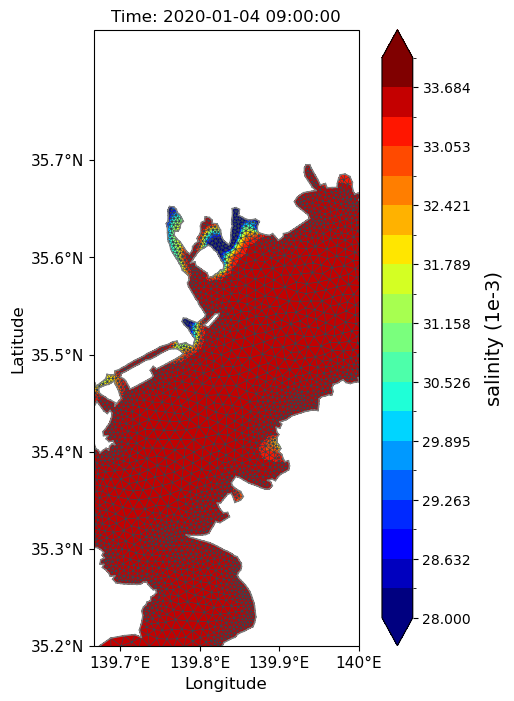

In [7]:
def custom_plot(ax, da, time):
    """
    Plot the corresponding datetime at each frame and set xlim and ylim

    Parameters:
    - ax: matplotib axis.
    - da: DataArray.
    - time: Frame time.
    """

    # Put datetime text.
    datetime = pd.Timestamp(da.time.item()).strftime('%Y-%m-%d %H:%M:%S')
    ax.set_title(f"Time: {datetime}")

    # Set xlim and ylim manually.
    xlim = ("139:40:00", "140:00:00")
    ylim = ("35:12:00", "35:50")
    #xlim = (139.7, 140.1)
    #ylim = (35, 35.6)

    apply_xlim_ylim(ax, xlim, ylim, is_cartesian=False)

# Set plot_kwargs for `ax.tricontourf(**kwargs)`.
plot_kwargs={"verbose": False, "vmin": 10, "vmax": 20, "levels": [9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 15, 16, 17, 18, 19, 20]}
plot_kwargs={"verbose": False, "vmin": 28, "vmax": 34, "levels": 20, "cmap": "jet", "with_mesh": True, "coastlines": True}

FrameGenerator.plot_data(data_array=da, time=time, plotter=plotter,
    save_path=save_path, post_process_func=custom_plot, plot_kwargs=plot_kwargs)